In [1]:
import pickle

with open('../../PNC_Good/MegaMeta3.pkl', 'rb') as f: 
    meta = pickle.load(f)
    
print('Complete')

Complete


In [2]:
with open('../../Work/LatentSim/Splits.pkl', 'rb') as f:
    keys, groups = pickle.load(f)
    
print(len(keys))
print(len(groups[0][0])+len(groups[0][1]))
print('Complete')

620
620
Complete


In [3]:
import numpy as np

nback = np.stack([meta[key]['nback'] for key in keys])
emoid = np.stack([meta[key]['emoid'] for key in keys])

print(nback.shape)
print(emoid.shape)

(620, 264, 231)
(620, 264, 210)


In [5]:
from nilearn.connectome import ConnectivityMeasure

def getFC(timeSeries, kind='correlation', transpose=True):
    connMeasure = ConnectivityMeasure(kind=kind)
    if transpose:
        timeSeries = np.transpose(timeSeries, axes=(0,2,1))
    return connMeasure.fit_transform(timeSeries)

nback_p = getFC(nback)
emoid_p = getFC(emoid)

print(nback_p.shape)

(620, 264, 264)


In [6]:
import torch

def convertTorch(p):
    t = torch.from_numpy(p).float()
    u = []
    for i in range(t.shape[0]):
        u.append(t[i][torch.triu_indices(264,264,offset=1).unbind()])
    return torch.stack(u).cuda()

nback_p_t = convertTorch(nback_p)
emoid_p_t = convertTorch(emoid_p)

print(nback_p_t.shape)
print(emoid_p_t.shape)
print('Complete')

torch.Size([620, 34716])
torch.Size([620, 34716])
Complete


In [7]:
mu_nback = torch.mean(nback_p_t, dim=0, keepdim=True)
mu_emoid = torch.mean(emoid_p_t, dim=0, keepdim=True)
std_nback = torch.std(nback_p_t, dim=0, keepdim=True)
std_emoid = torch.std(emoid_p_t, dim=0, keepdim=True)

nback_p_t = (nback_p_t - mu_nback)/std_nback
emoid_p_t = (emoid_p_t - mu_emoid)/std_emoid

print(torch.min(nback_p_t[:,420:422],dim=0))
print(torch.min(emoid_p_t[:,420:422],dim=0))

torch.return_types.min(
values=tensor([-2.2998, -3.0133], device='cuda:0'),
indices=tensor([603, 350], device='cuda:0'))
torch.return_types.min(
values=tensor([-2.7284, -3.0616], device='cuda:0'),
indices=tensor([351,  33], device='cuda:0'))


In [8]:
age = np.stack([meta[key]['AgeInMonths'] for key in keys])
gen = np.stack([np.array([meta[key]['Gender'] == 'M', meta[key]['Gender'] == 'F']) for key in keys]).astype(int)
wrt = np.stack([meta[key]['wratStd'] for key in keys])

print(age.shape)
print(gen.shape)
print(wrt.shape)

age_t = torch.from_numpy(age).float().cuda()
gen_t = torch.from_numpy(gen).float().cuda()
wrt_t = torch.from_numpy(wrt).float().cuda()

print('Complete')

(620,)
(620, 2)
(620,)
Complete


In [169]:
import torch.nn as nn
import torch.nn.functional as F
import time

ceLoss = torch.nn.CrossEntropyLoss()
mseLoss = torch.nn.MSELoss()

rmse = []
Ass = []

def allBelowThresh(losses, thresh):
    for loss,thr in zip(losses, thresh):
        if loss > thr:
            return False
    return True

def flatten(res):
    flat = [r for re in res for r in re]
    return flat

def mask(e):
    return e - torch.diag(torch.diag(e.detach()))

def arith(n):
    return int(n*(n+1)/2)

def getAvg(res):
    nPara = len(res)
    nTasks = len(res[0])
    avg = []
    for task in range(nTasks):
        avg.append(0)
        for para in range(nPara):
            avg[-1] += res[para][task]/nPara
    return avg

class LatSim(nn.Module):
    def __init__(self, nTasks, inp, dp=0.5, edp=0.1, wInit=1e-4, dimA=10, dimB=2, temp=1):
        super(LatSim, self).__init__()
        self.nTasks = nTasks
        self.A = nn.Parameter(wInit*torch.randn(2,inp.shape[-1],dimA).float().cuda())
        self.B = nn.Parameter(wInit*torch.randn(2,nTasks,dimA,dimB).float().cuda())
        self.dp = nn.Dropout(p=dp)
        self.edp = nn.Dropout(p=edp)
        self.t = temp if isinstance(temp, list) else nTasks*[temp]
    
    def getLatent(self, x, para):
        return x[:,para]@self.A[para]
    
    def getEdges(self, A, para, task):
        e = 1e-10
        z = A@self.B[para, task]
        e = e+z@z.T
        return e
        
    def forward(self, x, ys, testIdcs=None):
        assert self.B.shape[1] == len(ys), "business end targets dim not same as passed"
        x = self.dp(x)
        res = []
        As = []
        es = []
        for para in range(2):
            A = self.getLatent(x, para)
            As.append(F.relu(A))
        for para,A in enumerate(As):
            res.append([])
            for task,y in enumerate(ys):
                e = self.getEdges(A, para, task)
                if testIdcs is not None:
                    e[:,testIdcs] = 0
                e = mask(e)
                e = self.edp(e)
                e[e == 0] = float('-inf')
                e = F.softmax(e/self.t[task], dim=1)
                res[-1].append(e@y)
        return res, As, es

def validate(model, X, ys, testIdcs):
    model.eval()
    losses = []
    with torch.no_grad():
        res, _, _ = model(X, ys, testIdcs)
        # for r,y in zip(res, ys):
        for r,y in zip(getAvg(res), ys):
            if y.dim() == 1:
                loss = mseLoss(r[testIdcs], y[testIdcs]).cpu().numpy()**0.5
                losses.append(loss)
            else:
                corr = (torch.argmax(r, dim=1) == torch.argmax(y, dim=1))[testIdcs]
                loss = torch.sum(corr)/len(testIdcs)
                losses.append(loss)
    model.train()
    return losses

def getAs(model, X, ys):
    model.eval()
    As = None
    with torch.no_grad():
        _, As, _ = model(X, ys)
    model.train()
    return As

def binLoss(w):
    mag = torch.abs(w)
    maxMag = torch.max(mag, keepdim=True, dim=1).values
    p = mag/maxMag
    return -torch.sum(p*torch.log(p+1e-10))

nEpochs = 1500
pPeriod = 50
thresh = [20,0.3,10]
regParam = [1,1e3,20]
binParam = 1e-1

for grp in range(1):
    trainIdcs = groups[grp][0][0:496]
    trainValidIdcs = groups[grp][0]
    validIdcs = np.arange(496,len(trainValidIdcs))
    testIdcs = groups[grp][1]

    X0 = nback_p_t
    X1 = emoid_p_t

    X = torch.stack([X0, X1], dim=1)
    Xt = X[trainIdcs]
    Xtv = X[trainValidIdcs]

    yy = [age_t, gen_t, wrt_t]
    yt = [age_t[trainIdcs], gen_t[trainIdcs], wrt_t[trainIdcs]]
    ytv = [age_t[trainValidIdcs], gen_t[trainValidIdcs], wrt_t[trainValidIdcs]]

    nTasks = len(yy)

    sim = LatSim(nTasks, X, dp=0.5, edp=0.1, wInit=1e-4, dimA=20, dimB=2, temp=[1,1,1])
    optim = torch.optim.Adam(sim.parameters(), lr=2e-4, weight_decay=2e-4)

    validLoss = [[] for _ in range(nTasks)]

    for epoch in range(nEpochs):
        optim.zero_grad()
        res, As, _ = sim(Xt, yt)
        loss = []
        for i,(r,y) in enumerate(zip(flatten(res)+getAvg(res), (X.shape[1]+1)*yt)):
            if y.dim() > 1:
                loss.append(regParam[i%nTasks]*ceLoss(r, y))
            else:
                loss.append(regParam[i%nTasks]*mseLoss(r, y))
        bloss = [binParam*binLoss(sim.A)]
        loss += bloss
        sum(loss).backward()
        optim.step()
        if epoch % pPeriod == 0 or epoch == nEpochs-1 or allBelowThresh(loss[0:nTasks], thresh):
            print(f'epoch {epoch} loss={bloss}')
            losses = validate(sim, Xtv, ytv, validIdcs)
            for i,lss in enumerate(losses):
                if (len(validLoss[i]) == 0 or 
                        (yy[i].dim() == 1 and lss < min(validLoss[i])) or 
                        (yy[i].dim() > 1 and lss > max(validLoss[i]))):
                    print(f'New best validation epoch {epoch} {i} loss={lss}')
                    torch.save(sim.state_dict(), f'../../Work/LatentSim/sim{i}.pyt')
                    validLoss[i].append(float(lss))
            if allBelowThresh(loss[0:nTasks], thresh):
                print('Early stopping')
                break

    finalLoss = []

    for i in range(nTasks):
        sim.load_state_dict(torch.load(f'../../Work/LatentSim/sim{i}.pyt'))
        loss = validate(sim, X, yy, testIdcs)
        if i == 0:
            Ass.append(getAs(sim, X, yy))
        finalLoss.append(float(loss[i]))

    rmse.append(finalLoss)

    print(f'FINISHED {rmse}')

epoch 0 loss=[tensor(36035.7188, device='cuda:0', grad_fn=<MulBackward0>)]
New best validation epoch 0 0 loss=44.584468841552734
New best validation epoch 0 1 loss=0.5
New best validation epoch 0 2 loss=12.045498847961426
epoch 50 loss=[tensor(8513.8438, device='cuda:0', grad_fn=<MulBackward0>)]
New best validation epoch 50 0 loss=44.581443786621094
New best validation epoch 50 2 loss=12.04539680480957
epoch 100 loss=[tensor(3319.6555, device='cuda:0', grad_fn=<MulBackward0>)]
New best validation epoch 100 0 loss=44.42740249633789
New best validation epoch 100 2 loss=12.044530868530273
epoch 150 loss=[tensor(3936.7937, device='cuda:0', grad_fn=<MulBackward0>)]
New best validation epoch 150 0 loss=38.46692657470703
New best validation epoch 150 1 loss=0.5806451439857483
New best validation epoch 150 2 loss=12.028901100158691
epoch 200 loss=[tensor(6253.4331, device='cuda:0', grad_fn=<MulBackward0>)]
New best validation epoch 200 0 loss=31.86172866821289
New best validation epoch 200 1 l

In [170]:
print(sum([f[0] for f in rmse])/len(rmse)/12)
print(sum([f[1] for f in rmse])/len(rmse))
print(sum([f[2] for f in rmse])/len(rmse))

2.2091708183288574
0.8548386693000793
12.747949600219727


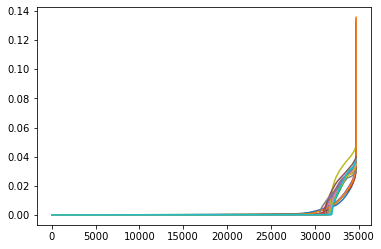

In [171]:
import matplotlib.pyplot as plt

w = sim.A[1].detach().cpu().numpy()

for dim in range(w.shape[1]):
    plt.plot(np.sort(np.abs(w[:,dim])))
plt.show()

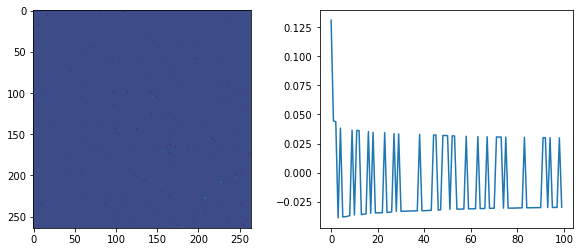

In [175]:
a,b = np.triu_indices(264, 1)

wsel = w[:,10]
idcs = np.argsort(-np.abs(wsel))[0:100]

img = np.zeros((264,264))
img[a[idcs],b[idcs]] = wsel[idcs]
img += img.T

fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].imshow(img)
ax[1].plot(wsel[idcs[0:100]])
plt.show()